In [2]:
%run ../draw_functions.py
%run ../kstest.py

In [3]:
from draw_functions import *
from kstest import *

In [4]:
#read csv
df = pd.read_csv('../csv/MX22312213AP01.csv')

#ajout du slope
df['slope'] = df.groupby('ResultCurve_id').apply(lambda group: group['xvalue'].diff() / group['xtime'].diff(), include_groups=False).reset_index(level=0, drop=True)
df_02_08 = df[(df['xtime'] >= 0.2) & (df['xtime'] <= 0.8)]
df_035_065 = df[(df['xtime'] >= 0.35) & (df['xtime'] <= 0.65)]
df

,ResultCurve_id,xtime,xvalue,Batch,Sample_Code,slope
0,92419C6B-1CD6-4F4B-9B3D-0775FF0D8B16,0.010000,1.660880,033901D,NBK0ISXU2,NaN
1,92419C6B-1CD6-4F4B-9B3D-0775FF0D8B16,0.020000,1.796462,033901D,NBK0ISXU2,13.558201
2,92419C6B-1CD6-4F4B-9B3D-0775FF0D8B16,0.030000,1.649581,033901D,NBK0ISXU2,-14.688051
3,92419C6B-1CD6-4F4B-9B3D-0775FF0D8B16,0.040000,1.525298,033901D,NBK0ISXU2,-12.428351
4,92419C6B-1CD6-4F4B-9B3D-0775FF0D8B16,0.047933,1.444626,033901D,NBK0ISXU2,-10.168650
...,...,...,...,...,...,...
475,834AFF50-1D2D-4E2E-A5F8-F9C95AFDE189,1.099400,11.567631,033901D,NBK0ISXVD,2.354046
476,834AFF50-1D2D-4E2E-A5F8-F9C95AFDE189,1.136667,11.648754,033901D,NBK0ISXVD,2.176831
477,834AFF50-1D2D-4E2E-A5F8-F9C95AFDE189,1.145000,11.682650,033901D,NBK0ISXVD,4.067460
478,834AFF50-1D2D-4E2E-A5F8-F9C95AFDE189,1.147200,11.685135,033901D,NBK0ISXVD,1.129850


## Analyse des pentes

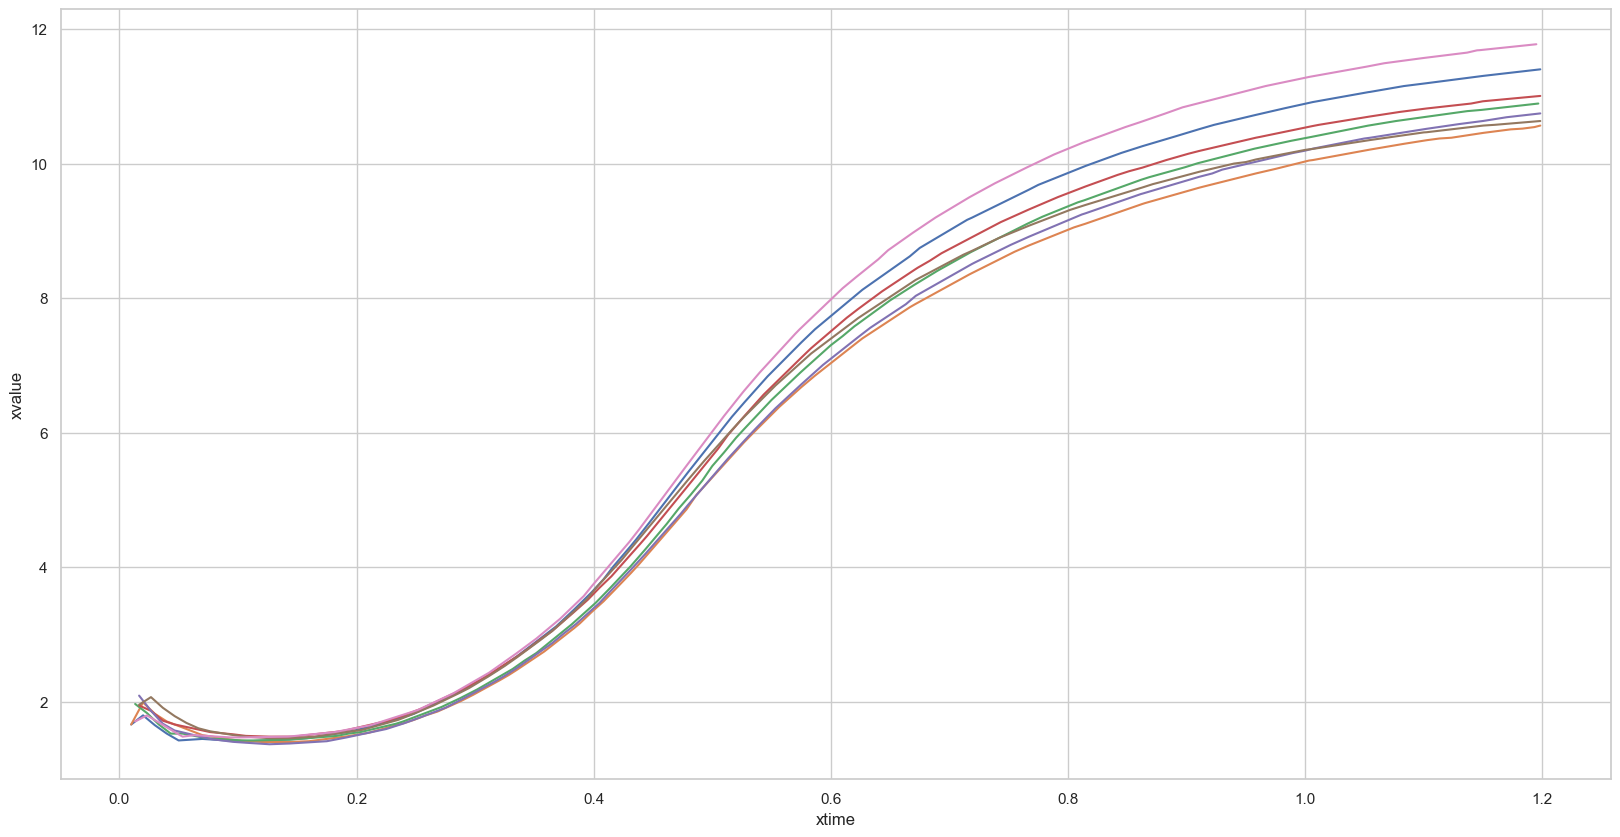

In [5]:
dessiner_commande(df)

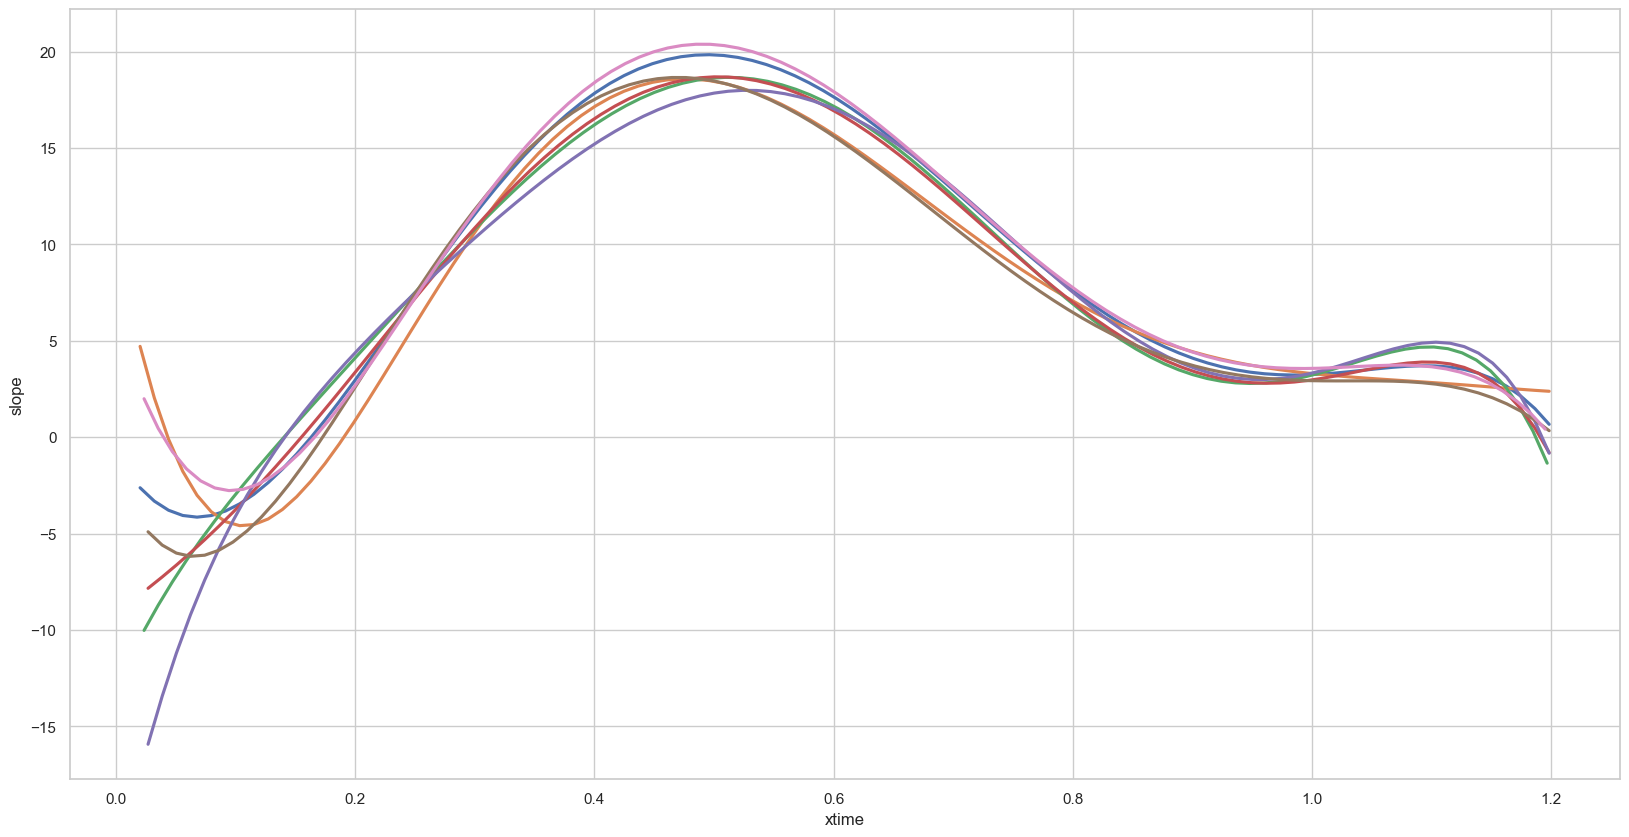

In [6]:
dessiner_commande_slope(df, 6 ,unified=False)

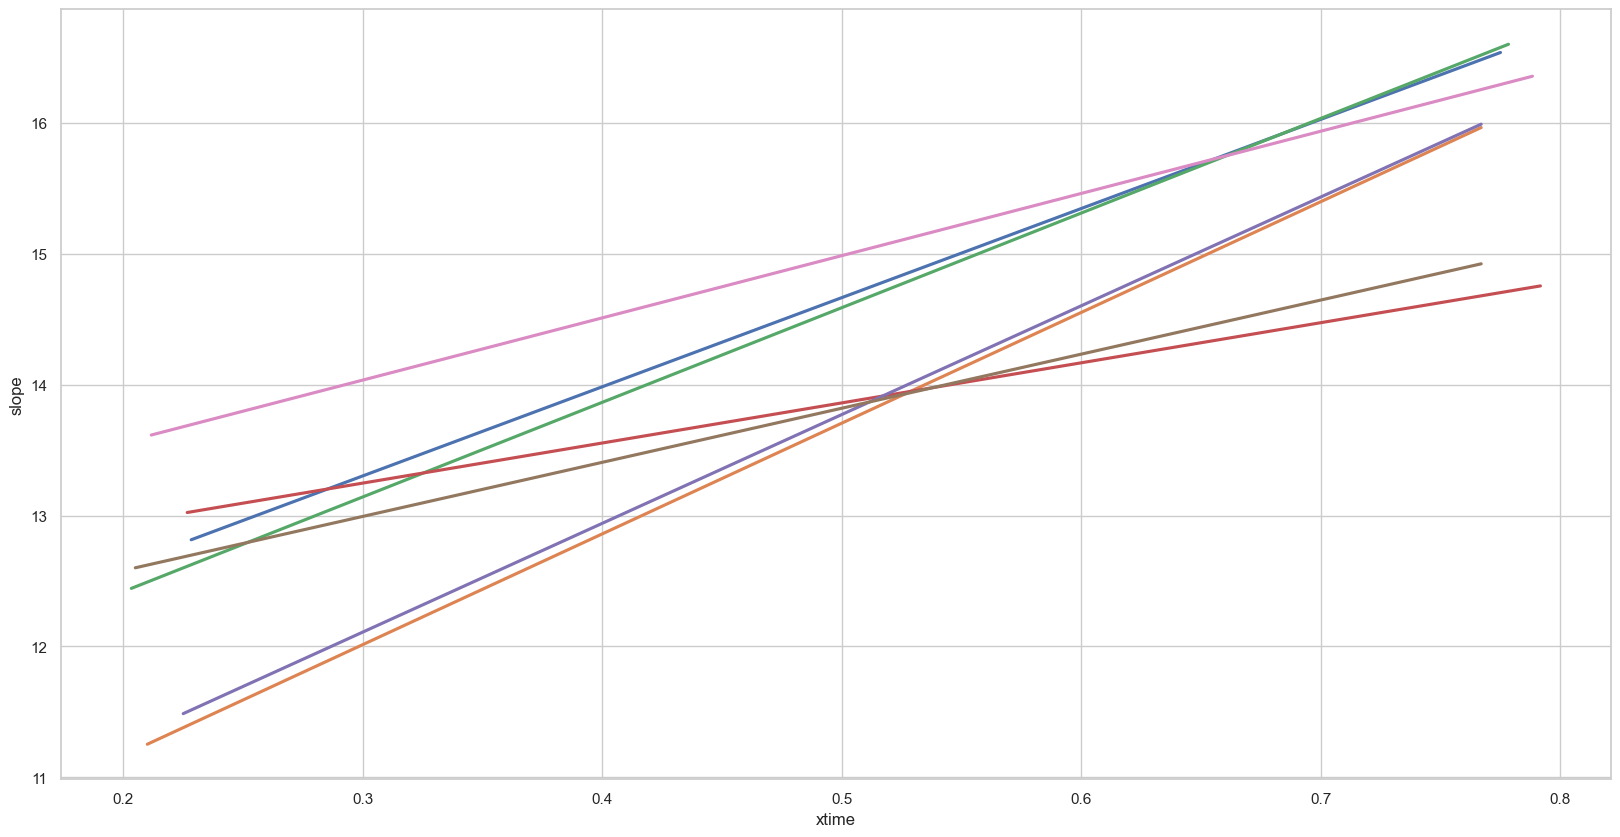

In [7]:
dessiner_commande_slope(df_02_08, 1 ,unified=False)

In [8]:
# Trouver le xtime correspondant au max de la pente pour chaque groupe
max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_batch_xtime = max_slope_sample_xtime.groupby('Batch').median()

# Calculer la médiane de xtime pour chaque groupe
median_xtime = max_slope_sample_xtime.median()

# Calculer la différence entre le xtime du max de la pente et la médiane de xtime pour chaque groupe
diff = max_slope_batch_xtime - median_xtime

# Sort the differences by their absolute values in descending order
diff_sorted = diff.abs().sort_values(ascending=False)

# Print the differences in the sorted order
for batch in diff_sorted.index:
    print(f"La différence de temps entre le max de la pente et la médiane pour le batch {batch} est : {round(diff_sorted[batch]*60,3)} seconde")

La différence de temps entre le max de la pente et la médiane pour le batch 033901D est : 0.0 seconde


In [9]:
#round xtime to 2 decimal places
df['xtime'] = df['xtime'].round(2)

# Trier le DataFrame par 'xtime' puis par 'xvalue'
df_sorted = df.sort_values(['xtime', 'xvalue'])

# Grouper par 'xtime' et calculer la différence entre deux 'xvalue' consécutifs
df_sorted['xvalue_diff'] = df_sorted.groupby('xtime')['xvalue'].diff().abs()

# Grouper par 'xtime' et exclure la première et la dernière valeur
grouped = df_sorted.groupby('xtime')

# For each group, select all rows except the first and last, then calculate the max
max_diff = grouped.apply(lambda group: group.iloc[1:-1]['xvalue_diff'].max(), include_groups=False)

# Créer une nouvelle DataFrame à partir des différences maximales
df_max_diff = pd.DataFrame(max_diff).reset_index()
# Rename the unnamed column
df_max_diff = df_max_diff.rename(columns={df_max_diff.columns[1]: 'xvalue_diff'})

df_max_diff

,xtime,xvalue_diff
0,0.01,0.045194
1,0.02,0.112985
2,0.03,0.158179
3,0.04,0.146881
4,0.05,0.111403
...,...,...
105,1.16,NaN
106,1.17,NaN
107,1.18,NaN
108,1.19,NaN


<Axes: xlabel='xtime', ylabel='xvalue_diff'>

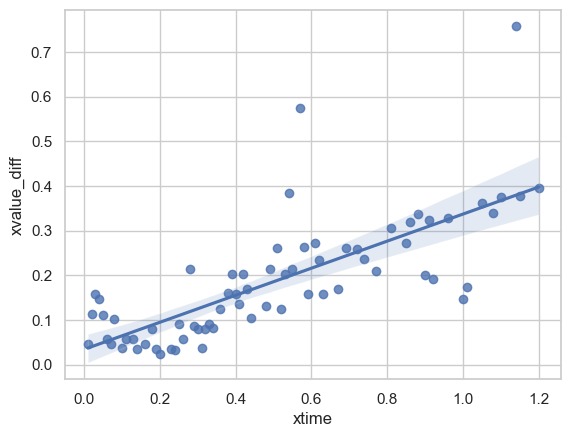

In [10]:
# Plot the max differences
sns.regplot(x='xtime', y='xvalue_diff', data=df_max_diff, scatter=True)

In [11]:
for sample in df_02_08['Sample_Code'].unique():
    df_sample = df_02_08[df_02_08['Sample_Code'] == sample]

    z1 = np.polyfit(df_sample['xtime'], df_sample['slope'], 3)
    p1 = np.poly1d(z1)

    # Update the 'fitted_slope' in df_data for the current sample
    df_02_08.loc[df_02_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])
max_slope_sample_xtime = df_02_08.loc[df_02_08.groupby('Sample_Code')['fitted_slope'].idxmax()][['Batch', 'xtime']].set_index('Batch')['xtime']
max_slope_sample_xtime

C:\Users\510215\AppData\Local\Temp\ipykernel_23356\2521058582.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_02_08.loc[df_02_08['Sample_Code'] == sample, 'fitted_slope'] = p1(df_sample['xtime'])


Batch
033901D    0.479333
033901D    0.479333
033901D    0.478000
033901D    0.513333
033901D    0.486667
033901D    0.491667
033901D    0.479333
Name: xtime, dtype: float64

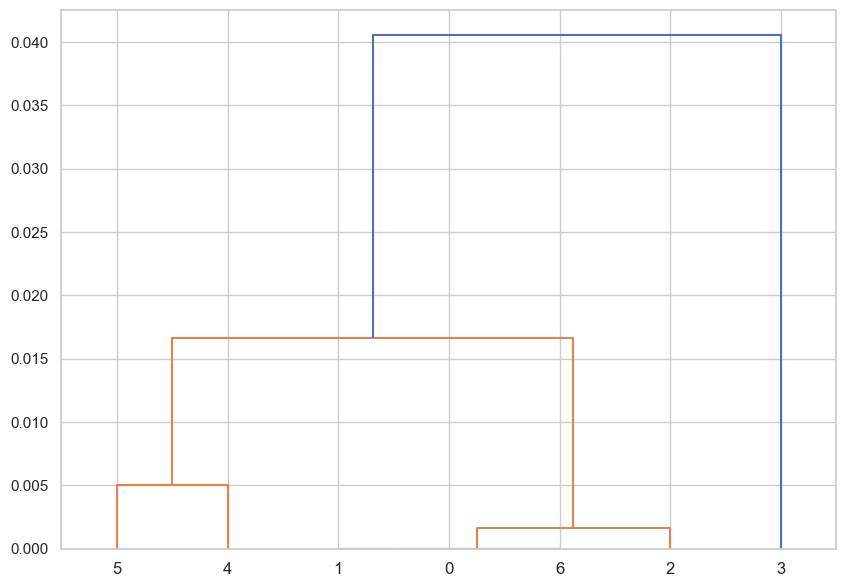

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Reshape your data to a 2D array
data = np.array(max_slope_sample_xtime).reshape(-1, 1)

# Generate the links between the clusters
linked = linkage(data, 'ward')

# Create a new plot
plt.figure(figsize=(10, 7))

# Draw the dendrogram
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Show the plot
plt.show()